### Function code

In [57]:
import numpy as np
import os
from scipy import sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
# Sorry for this code : (
import sys
sys.path.append('../')

from loader import get_newest_name, load_experiment_generator
from settings import Params

doc_pars, heart_pars, w_in, w, w_out, leaky_mask, path, name, g_core = (None,) * 9

def initialize_core(experiment_name, core):
    global doc_pars, heart_pars, w_in, w, w_out, leaky_mask, path, name, g_core

    name = get_newest_name(experiment_name, "../doctors")
    print(f"[{name}] core {core}")
    
    g_core = core

    path = os.path.abspath(f"../doctors/{name}/")

    doc_pars = Params(os.path.join(path, f"doctor_params_{core}.json"))
    heart_pars = Params(os.path.abspath(os.path.join("..", "hearts", doc_pars.get("dataset"), "params.json")))
    w_in = sp.load_npz(os.path.join(path, f"w_in_{core}.npz")).toarray()
    w = sp.load_npz(os.path.join(path, f"w_{core}.npz")).toarray()
    w_out = np.load(os.path.join(path, f"w_out_{core}.npy"))
    leaky_mask = np.load(os.path.join(path, f"leaky_mask_{core}.npy"))

    print("W_in", "max", "mean", "sd")
    print(np.max(np.abs(w_in)), np.mean(w_in), np.std(w_in))

    print("W", "max", "mean", "sd")
    print(np.max(np.abs(w)), np.mean(w), np.std(w))

    print("W_out", "max", "mean", "sd")
    print(np.max(np.abs(w_out)), np.mean(w_out), np.std(w_out))

    print("W spectral radius")
    print(np.max(np.abs(np.linalg.eigvals(w))))

def plot_activations_heart_like(begin, window, n_neurons):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=90)

    heart_like = os.path.isfile(os.path.join(path, f"neurons_local_{g_core}.npy"))

    if not heart_like:
        print("No heart like neurons detected")
        return

    neurons_local = np.load(os.path.join(path, f"neurons_local_{g_core}.npy"))
    neurons_other = np.load(os.path.join(path, f"neurons_other_{g_core}.npy"))

    period = 1000 / heart_pars.get("sampling_frequency")
    n = np.arange(neurons_local.shape[1]) * period

    indicies = (n >= begin) & (n < (begin + window))

    for i in range(n_neurons):
        ax[0].plot(n[indicies], neurons_local[i][indicies])
        ax[1].plot(n[indicies], neurons_other[i][indicies])

    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Activations")
    ax[0].set_title("Heart neurons")

    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Activations")
    ax[1].set_title("Other neurons")

    plt.show()


def plot_u_x_y(begin, window, n_neurons):
    fig, ax = plt.subplots(3, 1, figsize=(10, 15), dpi=90)

    neurons_logged = os.path.isfile(os.path.join(path, f"neurons_{g_core}.npy"))

    if not neurons_logged:
        print("No neurons detected")
        return

    u = np.load(os.path.join(path, f"u_{g_core}.npy")).T
    neurons = np.load(os.path.join(path, f"neurons_{g_core}.npy")).T
    y = np.load(os.path.join(path, f"y_{g_core}.npy")).T

    period = 1000 / heart_pars.get("sampling_frequency")
    n = np.arange(u.shape[1]) * period

    indicies = (n >= begin) & (n < (begin + window))

    for i in range(n_neurons):
        ax[0].plot(n[indicies], u[i][indicies])
        ax[1].plot(n[indicies], neurons[i][indicies])
        ax[2].plot(n[indicies], y[i][indicies])

    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("$u(t)$")
    ax[0].set_title("Input")

    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("$x(t)$")
    ax[1].set_title("Reserviour")

    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("$y(t)$")
    ax[2].set_title("Teacher")

    plt.show()

def plot_predictions(begin, window, n_neurons):

    fig, ax = plt.subplots(4, 1, figsize=(10, 20), dpi=90)

    test_logged = os.path.isfile(os.path.join(path, f"neurons_test_{g_core}.npy"))

    if not test_logged:
        print("No neurons detected")
        return

    u = np.load(os.path.join(path, f"u_test_{g_core}.npy")).T
    neurons = np.load(os.path.join(path, f"neurons_test_{g_core}.npy")).T
    y = np.load(os.path.join(path, f"y_test_{g_core}.npy")).T
    yhat = np.load(os.path.join(path, f"yhat_test_{g_core}.npy")).T

    delta = np.mean((yhat - y) * (yhat - y), axis=0)
    variances = np.var(y, axis=0)
    NMSE = delta / variances
    NRMSE = np.sqrt(NMSE)
    NRMSE = np.mean(NRMSE)
    print(f"NRMSE: {NRMSE}")

    period = 1000 / heart_pars.get("sampling_frequency")
    n = np.arange(u.shape[1]) * period

    indicies = (n >= begin) & (n < (begin + window))

    for i in range(n_neurons):
        ax[0].plot(n[indicies], u[i][indicies])
        ax[1].plot(n[indicies], neurons[i][indicies])
        ax[2].plot(n[indicies], y[i][indicies])
        ax[2].plot(n[indicies], yhat[i][indicies])

    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("$u(t)$")
    ax[0].set_title("Input")

    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("$x(t)$")
    ax[1].set_title("Reserviour")

    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("$y(t)$")
    ax[2].set_title("Teacher")

    ax[3].set_xlabel("Time")
    ax[3].set_ylabel("$yhat(t)$")
    ax[3].set_title("Prediction")

    plt.show()

def fast_append_and_insert_one(vectorA, vectorB):
        result = np.ones((vectorA.size + vectorB.size + 1, 1))
        result[1 : vectorA.size + 1] = vectorA
        result[vectorA.size + 1:] = vectorB
        return result

def calc_difference(x1, x2):
        return np.linalg.norm(x1 - x2)

def display_echo_state_property(start, end, forward_passes):

    generator = load_experiment_generator(
        "peregrine_big",
        os.path.abspath(os.path.join("..", 'hearts'))
    )

    states, actions = next(generator)

    s_min, s_max = [heart_pars.get("min_Vm"), heart_pars.get("max_Vm")]
    a_min, a_max = [heart_pars.get("min_action"), heart_pars.get("max_action")]

    s_shape = states.shape
    states = np.reshape(states, (s_shape[0], s_shape[1], 1))
    a_shape = actions.shape
    actions = np.reshape(actions, (a_shape[0], a_shape[1], 1))

    n_samples = s_shape[0]

    states = (states - s_min) / (s_max - s_min)
    actions = (actions - a_min) / (a_max - a_min)

    inspect_neurons = 10
    n_reserviour = w.shape[0]
    indicies = np.random.choice(np.arange(n_reserviour), size=inspect_neurons, replace=False)

    x1 = np.random.random((n_reserviour, 1))
    x2 = np.random.random((n_reserviour, 1))

    x1_trajectory = [
        np.squeeze(x1[indicies])
    ]

    x2_trajectory = [
        np.squeeze(x2[indicies])
    ]

    difference = [
        calc_difference(x1, x2)
    ]

    d = doc_pars.get("d")

    for i in range(forward_passes):

        if i + d >= n_samples:
            break

        u_now = states[i]
        y = actions[i]
        
        u_future = states[i + d]

        u = fast_append_and_insert_one(u_now, u_future)

        x1 = x1 * (1 - leaky_mask) + leaky_mask * np.tanh(
            w_in.dot(u) +
            w.dot(x1)
        )

        x2 = x2 * (1 - leaky_mask) + leaky_mask * np.tanh(
            w_in.dot(u) +
            w.dot(x2)
        )

        x1_trajectory.append(np.squeeze(x1[indicies]))
        x2_trajectory.append(np.squeeze(x2[indicies]))
        difference.append(calc_difference(x1, x2))

    x1_trajectory = np.array(x1_trajectory).T
    x2_trajectory = np.array(x2_trajectory).T
    difference = np.array(difference)
    iterations = np.arange(difference.size)
    indicies = (iterations >= start) & (iterations < end) 

    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=90)

    ts = iterations[indicies]

    ax[0].plot(ts, difference[indicies])
    washout = doc_pars.get("washout")
    ax[0].axvline(washout, color="black", linestyle=":", label=f"washout difference {difference[washout]:.5f}")
    ax[0].legend()

    ax[1].plot(ts, x1_trajectory[4][indicies], color="green")
    ax[1].plot(ts, x1_trajectory[5][indicies], color="blue")
    ax[1].plot(ts, x1_trajectory[6][indicies], color="orange")

    ax[1].plot(ts, x2_trajectory[4][indicies], color="green", linestyle=":")
    ax[1].plot(ts, x2_trajectory[5][indicies], color="blue", linestyle=":")
    ax[1].axvline(washout, color="black", linestyle=":")
    ax[1].plot(ts, x2_trajectory[6][indicies], color="orange", linestyle=":")
    
    plt.show()

def diplay_hyper_optimization():
    hyper = os.path.isfile(os.path.join(path, "results.csv"))

    if not hyper:
        print(f"No hyper optimization was found for [{name}]")
        return
    
    df = pd.read_csv(os.path.join(path, "results.csv"))
    n_ivs = len(df.columns) - 1
    ivs = list(df.columns.values)
    del ivs[ivs.index("nrmse")]
    dv ="nrmse"
    
    # Determin the number of columns and rows for the figure
    n_cols = 3 if n_ivs > 3 else n_ivs
    n_rows = int(np.ceil(n_ivs / n_cols))
    # How many figures need to be deleted
    extra = n_rows * n_cols - n_ivs
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Case of only one independent variable
    if n_cols == 1:
        iv = ivs[0]
        ax.scatter(df[iv], df[dv], marker="x")
        ax.set_xlabel(iv)
        ax.set_ylabel(dv)
    # Case when there is only one row
    elif n_rows == 1:

        # Delete extra axes
        for i in range(1, extra + 1):
            fig.delaxes(ax[-i])
    
        for index, iv in enumerate(ivs):
            ax[index].scatter(df[iv], df[dv], marker="x")
            ax[index].set_xlabel(iv)
            ax[index].set_ylabel(dv)
    # Case of multiple rows
    else:
        # Delete extra axes
        for i in range(1, extra + 1):
            fig.delaxes(ax[-1, -i])

        for index, iv in enumerate(ivs):
            # Calculate the indicies of the figure
            i = int(np.floor(index / n_cols))
            j = index % n_cols

            ax[i, j].scatter(df[iv], df[dv], marker="x")
            ax[i, j].set_xlabel(iv)
            ax[i, j].set_ylabel(dv)
    

### Init statistics

In [58]:
experiment_name = "test_log"
core = 0
initialize_core(experiment_name, core)

[test_log-10] core 0
W_in max mean sd
0.00401108088047745 0.0018813232675105435 0.0006845007732653964
W max mean sd
0.008552935176930237 0.001499880450003099 0.0025118273981519566
W_out max mean sd
424.66094129905105 -0.003321294619262247 51.39697290774707
W spectral radius
0.900000000000001


### Hyper-optimization

In [59]:
diplay_hyper_optimization()

No hyper optimization was found for [test_log-10]


### Neurons

No heart like neurons detected


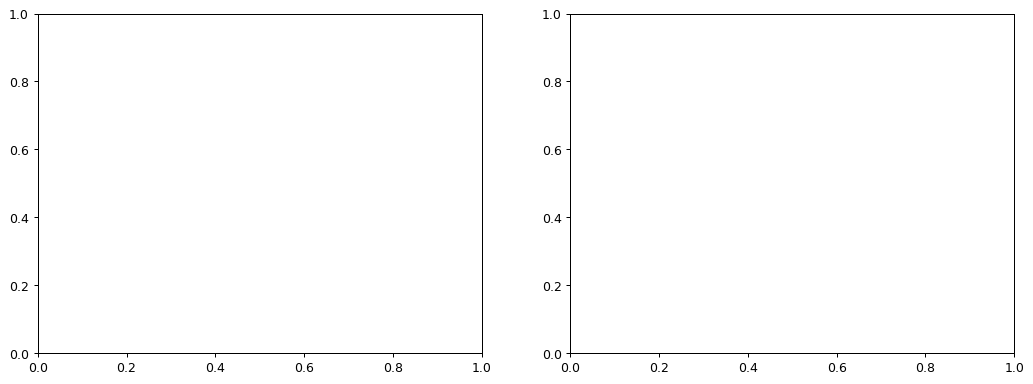

In [60]:
begin = 0
window = 4000
n_neurons = 10
plot_activations_heart_like(begin, window, n_neurons)

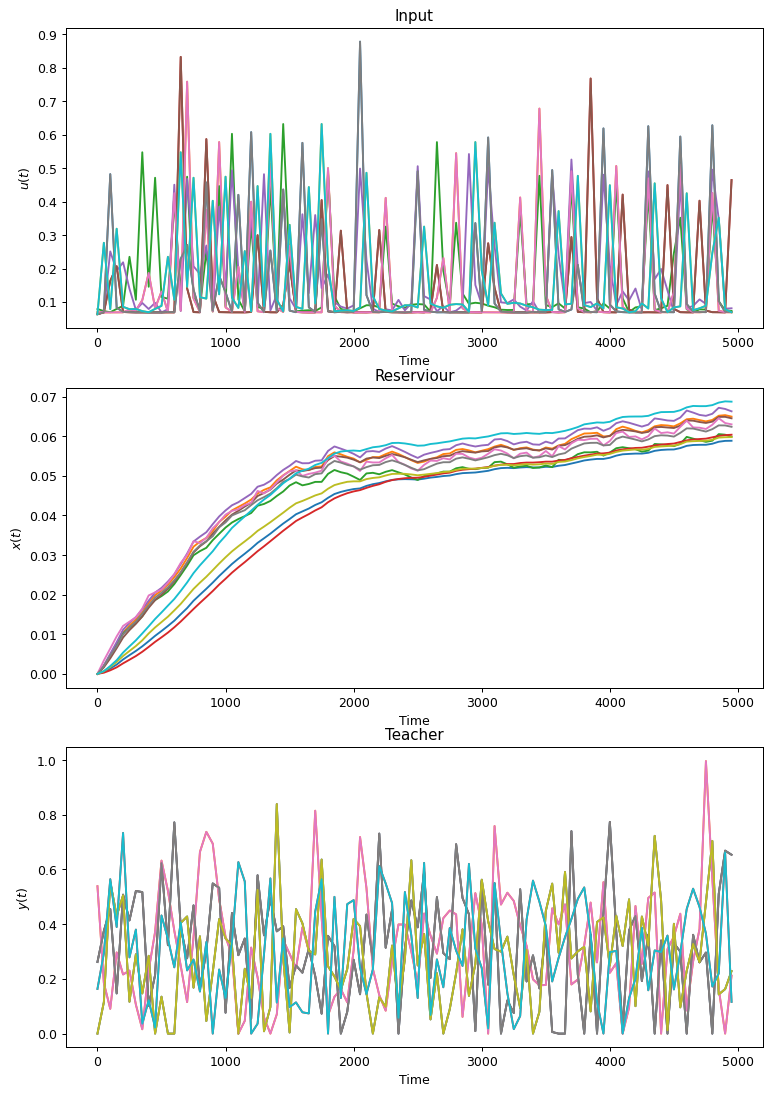

In [65]:
begin = 0
window = 5000
n_neurons = 10
plot_u_x_y(begin, window, n_neurons)

### Test

NRMSE: 1.242825032678827


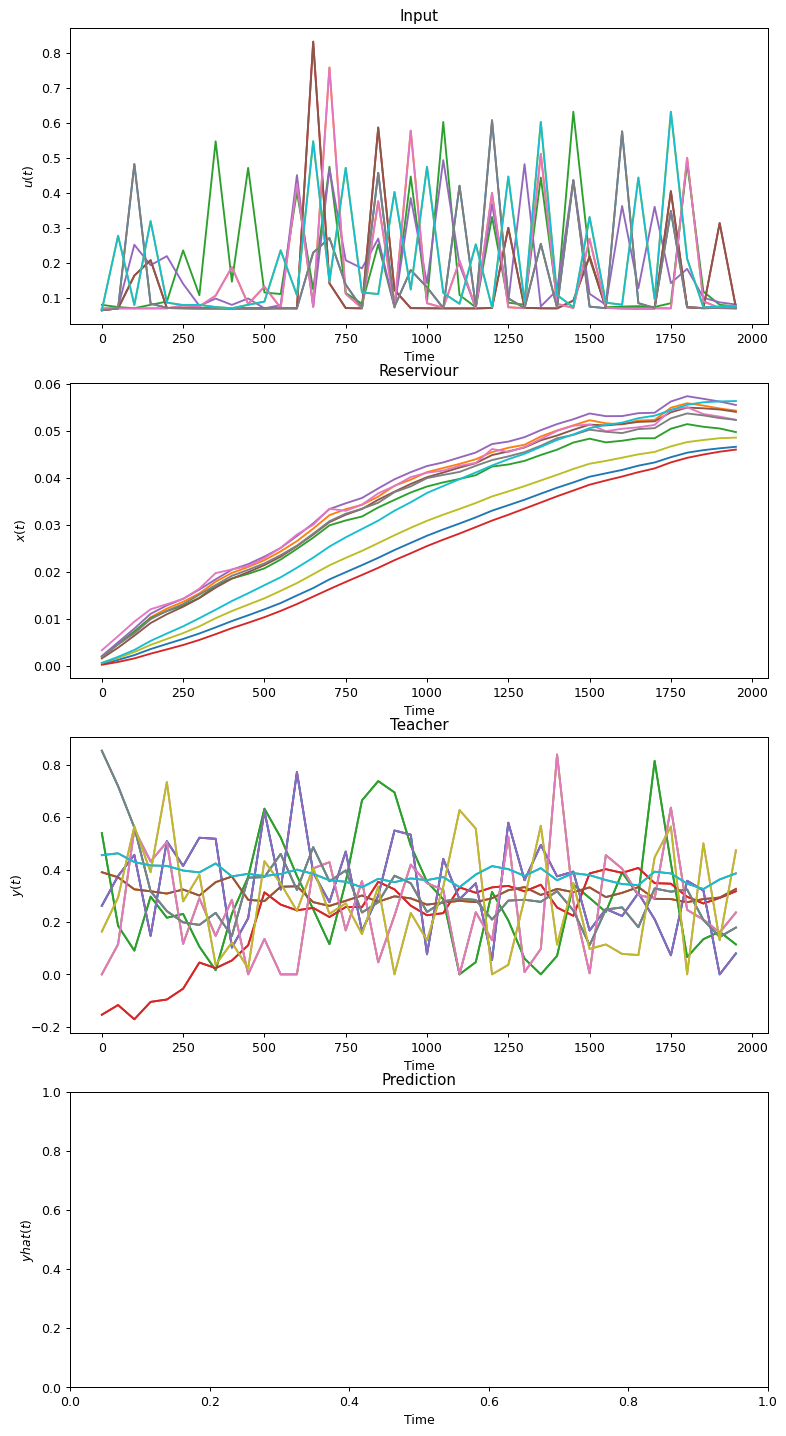

In [62]:
begin = 0
window = 2000
n_neurons = 10
plot_predictions(begin, window, n_neurons)

### Echo state property

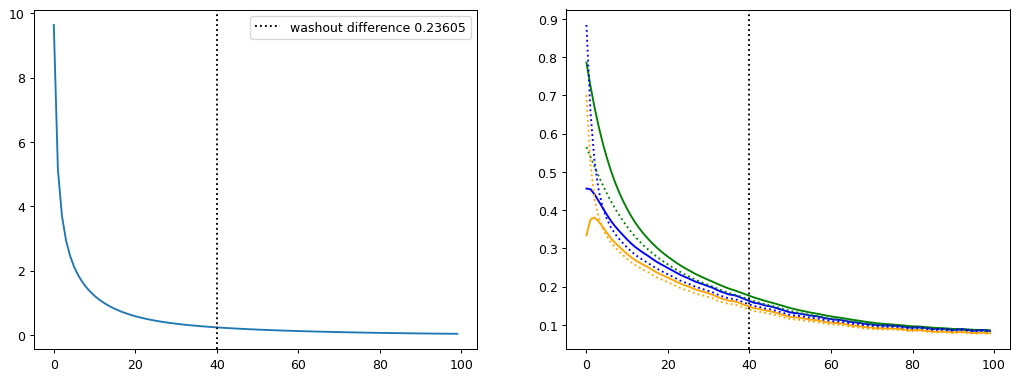

In [63]:
start = 0
end = 100
forward_passes = 200
display_echo_state_property(start, end, forward_passes)